In [1]:
%%capture
cd ..

In [2]:
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics

from palma import Project, ModelEvaluation, ModelSelector
from palma.components import ScoringAnalysis, ShapAnalysis
from palma.utils import plotting

In [3]:
from palma.datasets import load_credit_approval

X, y = load_credit_approval()

**Create the project**
To create vanilla project (without components), only input data $X$, target data $y$ and validation method needs to be provided

In [4]:
project = Project(problem="classification", project_name="test")
project.start(
    X, y,
    splitter=model_selection.ShuffleSplit(n_splits=4, random_state=42))

Here are representation of the validation strategy
* For validation steps
* For test steps

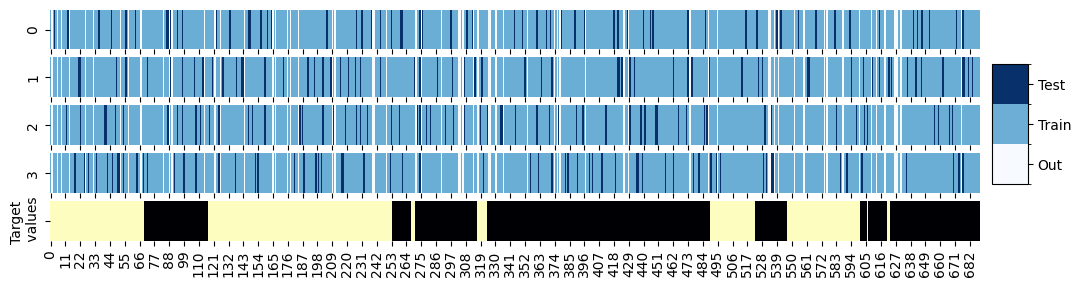

In [5]:
res = plotting.plot_splitting_strategy(
    project.X, project.y,
    iter_cross_validation=project.validation_strategy.indexes_val,
    cmap="rainbow_r")

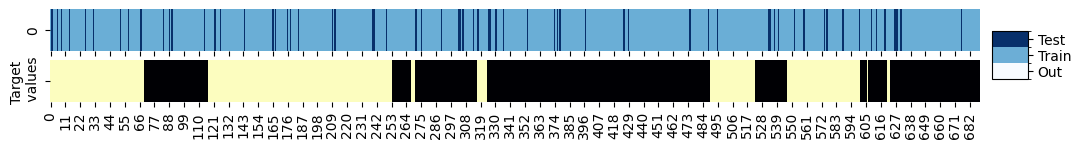

In [6]:
res = plotting.plot_splitting_strategy(
    project.X, project.y,
    iter_cross_validation=project.validation_strategy.indexes_train_test,
    cmap="rainbow_r")

**Run Opimization** 
Using the FLAML library, the best model (in a given estimator family) is searched

In [ ]:
%%capture
ms = ModelSelector(engine="FlamlOptimizer",
                   engine_parameters=dict(time_budget=20))
ms.start(project)

In [ ]:
ms.best_model_

**Analyse model** Once the best parameters and model is found, use the `ModelEvaluation` api to assess performance. Several built-in component are provided :
- `ScoringAnalysis`
- `RegressionAnalysis`
- `ShapAnalysis`

They can be related to either validation indexes (optimized by `ModelSelector`) or train/test indexes 

In [ ]:
%%capture
model = ModelEvaluation(estimator=ms.best_model_)
model.add(ScoringAnalysis(on="indexes_val"))
model.add(ShapAnalysis(on="indexes_val", n_shap=100))
model.fit(project)

In [ ]:
analyser = model.components["ScoringAnalysis"]
shap_analyser = model.components["ShapAnalysis"]

In [ ]:
f, ax = plt.subplots(figsize=(9, 5), ncols=2)

plt.sca(ax[0])
analyser.plot_roc_curve(plot_method="beam")
analyser.plot_roc_curve(plot_method="mean")
plt.sca(ax[1])
analyser.plot_roc_curve(plot_method="all", cmap="rainbow")
plt.show()


**[FOCUS] Explanantion tools**

1 . variable importance

In [ ]:
f, ax = plt.subplots(figsize=(8, 6), ncols=3)
plt.sca(ax[0])
analyser.plot_variable_importance(mode="minmax", color="blue")
plt.sca(ax[1])
analyser.plot_variable_importance(mode="std", color="lightgreen")
plt.sca(ax[2])
analyser.plot_variable_importance(mode="boxplot", cmap="rainbow_r")
plt.show()
analyser.variable_importance()

In [ ]:
shap_analyser.shap_expected_value

2. shap explanation 

In [ ]:
plt.figure(figsize=(5, 5))
shap_analyser.plot_shap_decision_plot()
plt.figure(figsize=(5, 5))
shap_analyser.plot_shap_summary_plot()

**Compute classification threshold**
Three methods are available to set the classification threshold

1. Corresponding to a provided fractile of the population targeted to one
2. Corresponding to a provided fractile of the positive true rate (recall) targeted to one
3. Corresponding to the optimized value of a provided metric

In [ ]:
print(analyser.compute_threshold(method="total_population", value=0.5))
print(analyser.compute_threshold(method="fpr", value=0.5))
print(analyser.compute_threshold(method="optimize_metric",
                                 metric=metrics.accuracy_score))

**Confusion matrix** corresponding to target 50% of the total population

In [ ]:
analyser.compute_threshold(method="total_population", value=0.5)
analyser.confusion_matrix(in_percentage=True)

**Confusion matrix** corresponding to an accpetance of 50% of false positive rate 

In [ ]:
analyser.compute_threshold(method="fpr", value=0.5)
analyser.confusion_matrix(in_percentage=True)

In [ ]:
plt.figure(figsize=(6, 6))

analyser.plot_roc_curve(plot_method="all", cmap="rocket")
analyser.plot_threshold(label="Threshold (FPR = 0.5)")
plt.legend(loc=4)